# Architecture OneClassSVM
A Support Vector Machine (SVM), supervised learning method that can be use for outliers detection.  
It takes arrays (vector) and determines the values and range that makes them similar. Then it will try to detect if any new data is part of the training set or not.

In [3]:
import junodch_utils_read_img as utils

import matplotlib.pyplot as matPlt
import numpy as np
from sklearn.svm import OneClassSVM
from shapely.geometry import Polygon

import rasterio
from rasterio import plot as rastPlt
from rasterio.mask import mask as rasterMask
from rasterio.plot import reshape_as_raster

# Data preparation
### Fetch data from file

In [4]:
def formatDataForSVM(data):
  return data.reshape(data.shape[0], -1)

def displayResultSVM(svm, dataInput, res=64):
  MAX_ON_ROW = 20
  total = len(dataInput)
  nRow = (total // MAX_ON_ROW) + 1
  nCol = MAX_ON_ROW if total > MAX_ON_ROW else total

  score = svm.predict(formatDataForSVM(dataInput))
  matPlt.figure(figsize=(30,nRow*2))
  for i in range(0, total):
    ax = matPlt.subplot(nRow, nCol, 1+i)
    matPlt.title('T' if score[i] == 1 else 'F')
    matPlt.imshow(dataInput[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  matPlt.show()


In [5]:
folderName = "img/Sokoto/"
pathSatellite = folderName + "Sentinel-2.tif"
pathNight = folderName + "Night_VIIRS.tif"
pathValidation = folderName + "Population_GHSL.tif"

aoi = utils.getImgBorder(pathSatellite)

# Fetch coords
dataCoords, dataRadiance = utils.getTilesCoordsPerimeter(pathNight, area=aoi)

lightMask = dataRadiance>0
lightCoords = dataCoords[lightMask]

print('Tiles:',dataCoords.shape[0])
print('Light Tile:',lightCoords.shape[0])

Tiles: 139113
Light Tile: 689


#### Fetch images

In [6]:
with rasterio.open(pathSatellite) as f:
  trainData, _ = utils.coordsToImgsFormated(f, lightCoords, res=64)
trainDataFormated = formatDataForSVM(trainData)
print(trainData.shape)
print(trainDataFormated.shape)

(689, 64, 64, 3)
(689, 12288)


### Validation
Extract the data from GHSL for the validation process

In [7]:
with rasterio.open(pathValidation) as f:
  sampleTile, _ = rasterMask(f, [Polygon(dataCoords[1000])], crop=True) # arbitrary coordinate for a sample
print('Validation shape:',sampleTile.shape) # shape sample

print('Process validation...')
# If any of the pixels have a settlement then true else false
getValid = lambda data : [ 0.9 < img.max() for img in data ]
resultValid = utils.scanSatellite(pathValidation, dataCoords, getValid, batch=1000, res=sampleTile.shape[1])

Validation shape: (4, 9, 9)
Process validation...


## svm
Train and validate

In [23]:
svm = OneClassSVM(verbose=False, gamma='scale', kernel='rbf', nu=0.1, tol=1e-3)
svm = svm.fit(trainDataFormated, sample_weight=dataRadiance[lightMask])

## Analyse model
Calculate all tiles prediction by the model.

In [26]:
print('Process score...')
getScore = lambda data : [i == 1 for i in svm.predict(formatDataForSVM(data))]
result = utils.scanSatellite(pathSatellite, dataCoords, getScore, batch=1000, res=64)

Process score...


### Confusion Matrix. 

In [27]:
utils.processConfusionMatrix(result, resultValid, lightMask)

Total light data: 689 Detected: 621 Missed: 68
Population with light detected: 90.13 %

Process confustion matrix...
total data: 139113
[[59466 56613]
 [ 9836 13198]]
f-score: 28.43 %


# Display the analysed results

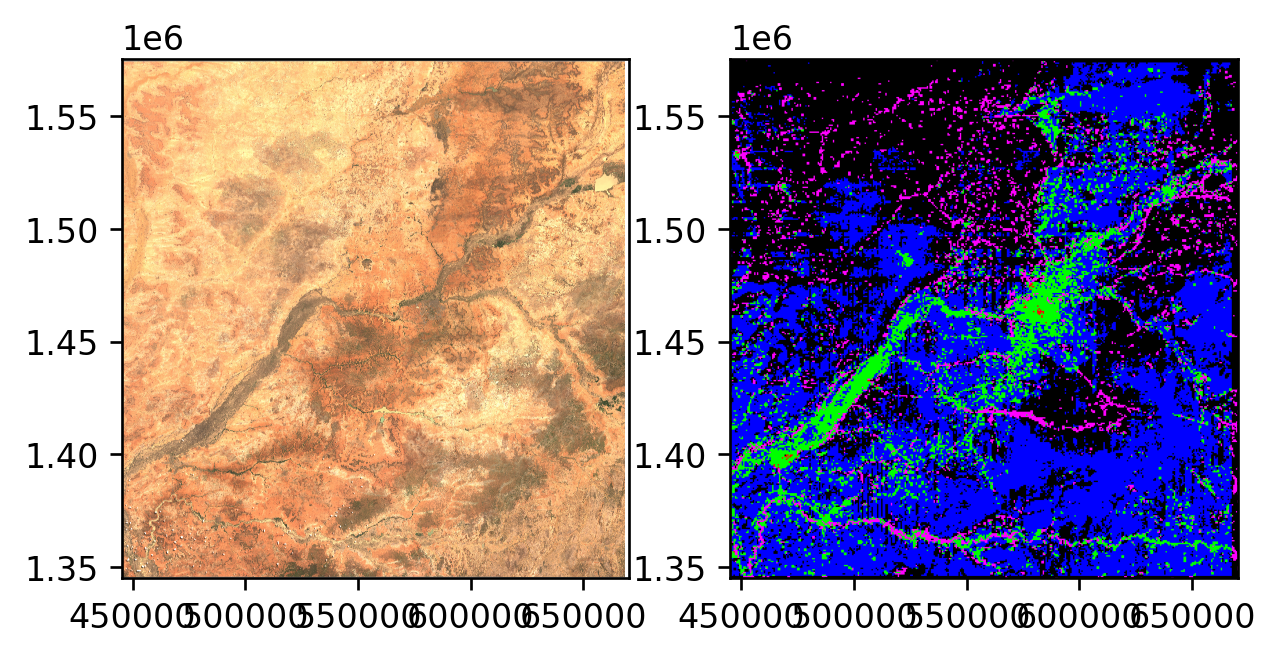

In [28]:
resultImg, resultMeta = utils.mapResultOnImg(pathNight, dataCoords, result, resultValid, lightMask)

fig, axs = matPlt.subplots(1,2, dpi=240)
with rasterio.open(pathSatellite) as s: utils.displayTiles([s.read()], [s.transform],axs[0])

axs[1].set_xlim(axs[0].get_xlim())
axs[1].set_ylim(axs[0].get_ylim())

utils.displayTiles([resultImg], [resultMeta], axs[1])


In [ ]:
img, profile = utils.rasterToImg(resultImg, pathNight)
with rasterio.open(folderName + 'svm_mu_08_Nigeria.tif', 'w', **profile) as f:
  f.write(img)


## Test

In [ ]:
indexesTest = [*np.argwhere(lightMask)[-20:].flatten(), *range(0,1), *range(1118,1127), *range(4005,4010), *range(10005,10010)]

with rasterio.open(pathSatellite) as f:
  dataTest, _ = utils.coordsToImgsFormated(f, dataCoords[indexesTest], res=64)

displayResultSVM(svm, dataTest)